In [1]:
import pandas as pd
import numpy as np
import re

from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

plt.style.use('seaborn')

rseed = 42

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
%matplotlib notebook

# Data

In [3]:
# load data
df = pd.read_csv('datasets/supermarket.csv')

In [4]:
# see data
df.head()

,Sales,Price.Eggs,Ad.Type,Price.Cookies
0,18,4.77,0,4.74
1,20,4.67,0,4.81
2,23,4.75,0,4.36
3,23,4.74,0,4.29
4,23,4.63,0,4.17


In [5]:
# check types
df.dtypes

Sales              int64
Price.Eggs       float64
Ad.Type            int64
Price.Cookies    float64
dtype: object

In [6]:
# clean-up
df.columns = [re.sub(r'\W+', '', x.lower()) for x in df.columns]
df['adtype'] = df['adtype'].astype('category')
df.dtypes

sales              int64
priceeggs        float64
adtype          category
pricecookies     float64
dtype: object

In [36]:
# set target and feature names
target = 'sales'
features = [c for c in df.columns if c != target]

In [37]:
# check for collinearity
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="jet")

In [38]:
# check for multicollinearity using VIF
dummy_features = "+".join(features)
_, X = dmatrices('sales ~' + dummy_features, df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,516.624613,Intercept
1,1.189436,adtype[T.1]
2,1.195107,priceeggs
3,1.006566,pricecookies


# Sklearn

In [40]:
# setup data
y = df[target]
X = df.drop(target, axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=rseed)

In [41]:
# Create linear regression object
lm = linear_model.LinearRegression()

# Train the model using the training sets
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Make predictions using the testing set
y_pred = lm.predict(X_test)

In [43]:
# The coefficients
print('{:12} {:12.2f}'.format('Intercept', lm.intercept_))
for feature, value in zip(feature_names, lm.coef_):
    print('{:12} {:12.2f}'.format(feature, value))
    
# The mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: {:.2f}".format(mse))

# Explained variance score: 1 is perfect prediction
r2 = r2_score(y_test, y_pred)
print('Variance score: {:.2f}'.format(r2))

Intercept          151.49
priceeggs          -17.92
adtype               4.11
pricecookies       -10.08
Mean squared error: 9.60
Variance score: 0.85


# Statsmodels

In [44]:
mod_form = target + '~' + '+'.join([f for f in features])

In [47]:
mod = sm.formula.ols(formula=mod_form, data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     67.14
Date:                Wed, 17 Jan 2018   Prob (F-statistic):           2.25e-12
Time:                        15:37:09   Log-Likelihood:                -69.210
No. Observations:                  30   AIC:                             146.4
Df Residuals:                      26   BIC:                             152.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      137.3699     10.834     12.680   

<IPython.core.display.Javascript object>


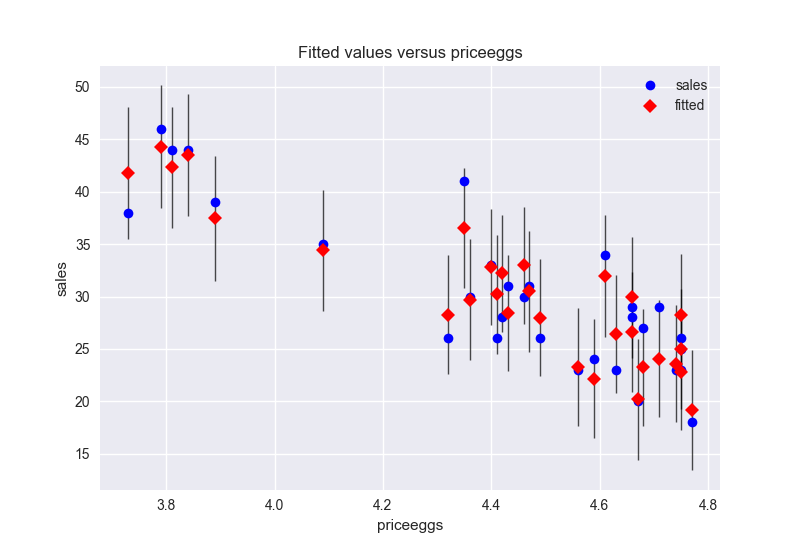

In [52]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(res, features[0], ax=ax)

<IPython.core.display.Javascript object>


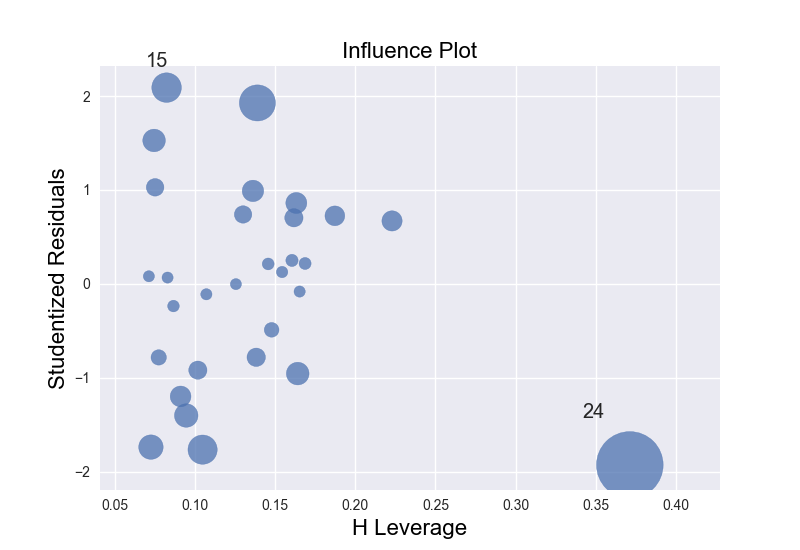

In [53]:
# influence plot
fig, ax = plt.subplots()
fig = sm.graphics.influence_plot(res, ax=ax, criterion="cooks")

<IPython.core.display.Javascript object>


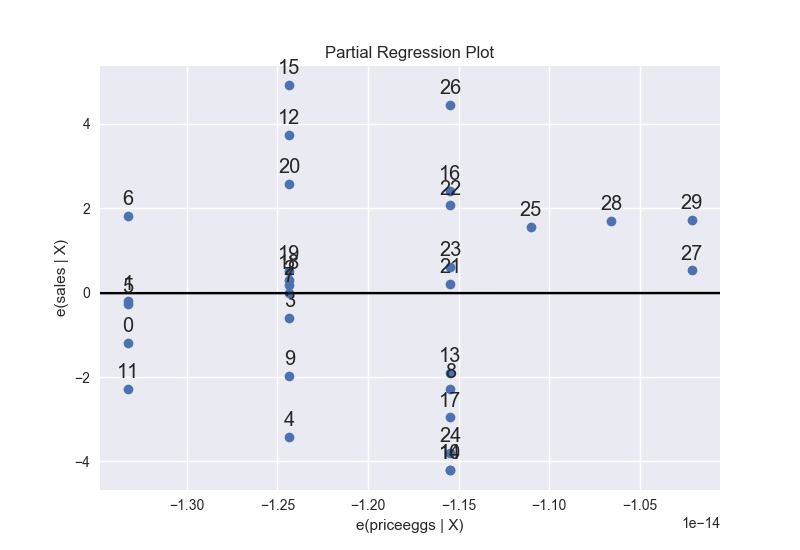

In [54]:
# partial regression
fig, ax = plt.subplots()
fig = sm.graphics.plot_partregress(target, features[0], features, data=df, ax=ax)

<IPython.core.display.Javascript object>


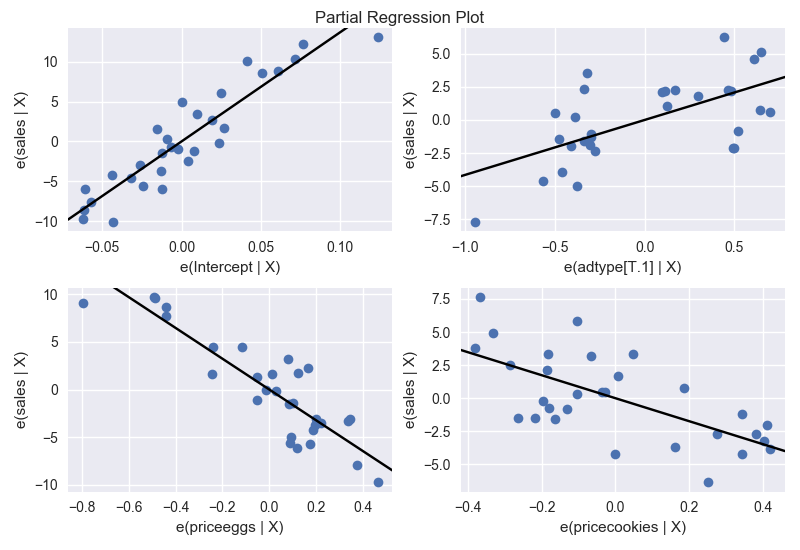

In [55]:
fig = plt.figure()
fig = sm.graphics.plot_partregress_grid(res, fig=fig)

<IPython.core.display.Javascript object>


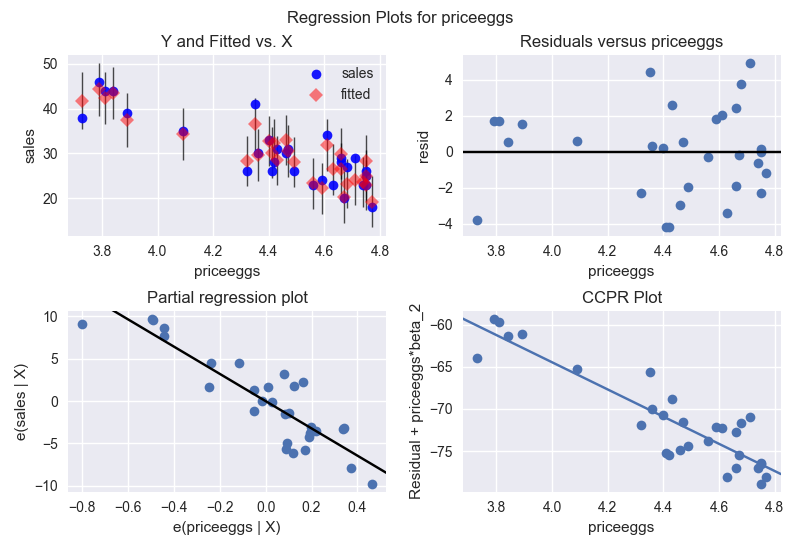

In [56]:
fig = plt.figure()
fig = sm.graphics.plot_regress_exog(res, features[0], fig=fig)

In [58]:
# fitted values (need a constant term for intercept)
model_fitted_y = res.fittedvalues

# model residuals
model_residuals = res.resid

# normalized residuals
model_norm_residuals = res.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = res.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = res.get_influence().cooks_distance[0]

<IPython.core.display.Javascript object>


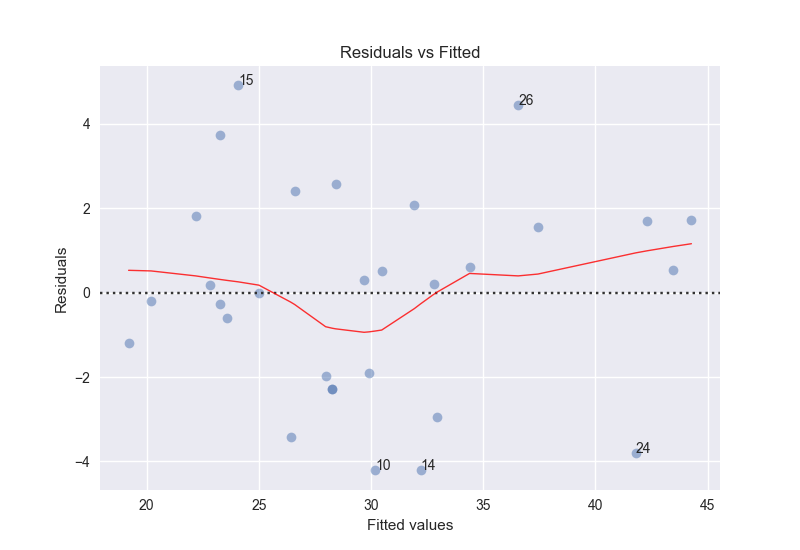

In [59]:
fig = plt.figure()
sns.residplot(model_fitted_y, target, data=df,
              lowess=True, 
              scatter_kws={'alpha': 0.5}, 
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
fig.axes[0].set_title('Residuals vs Fitted')
fig.axes[0].set_xlabel('Fitted values')
fig.axes[0].set_ylabel('Residuals')

# annotations
abs_resid = model_abs_resid.sort_values(ascending=False)
top_n = abs_resid[:5]
for i in top_n.index:
    fig.axes[0].annotate(i,
                         xy=(model_fitted_y[i], 
                             model_residuals[i]));

<IPython.core.display.Javascript object>


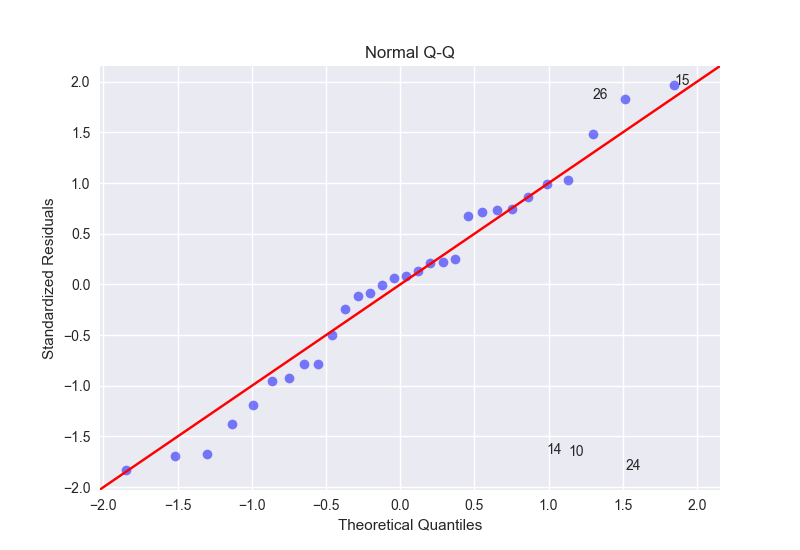

In [61]:
QQ = ProbPlot(model_norm_residuals)
fig = QQ.qqplot(line='45', alpha=0.5, color='b', lw=1)
fig.axes[0].set_title('Normal Q-Q')
fig.axes[0].set_xlabel('Theoretical Quantiles')
fig.axes[0].set_ylabel('Standardized Residuals');

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
top_n = abs_norm_resid[:5]
for r, i in enumerate(top_n):
    fig.axes[0].annotate(i, 
                         xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                             model_norm_residuals[i]));

<IPython.core.display.Javascript object>


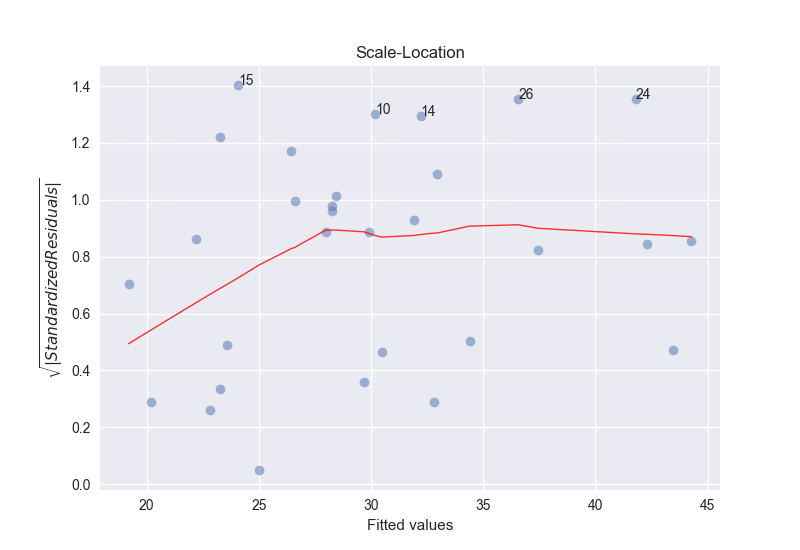

In [62]:
fig = plt.figure()
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            ci=False, 
            lowess=True, 
            scatter_kws={'alpha': 0.5}, 
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
fig.axes[0].set_title('Scale-Location')
fig.axes[0].set_xlabel('Fitted values')
fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

# annotations
abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
top_n = abs_sq_norm_resid[:5]
for i in top_n:
    fig.axes[0].annotate(i,
                         xy=(model_fitted_y[i], 
                             model_norm_residuals_abs_sqrt[i]));

<IPython.core.display.Javascript object>


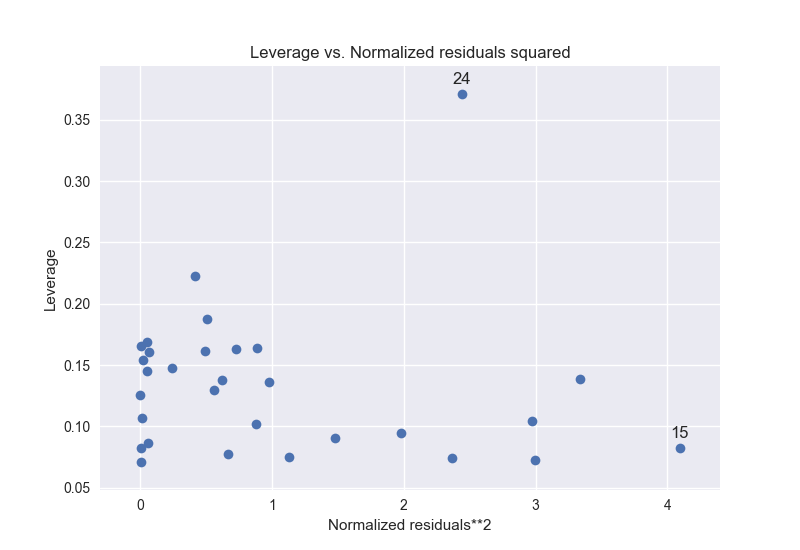

In [63]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_leverage_resid2(res, ax=ax)